In [2]:
from phi.flow import *
from phi import __version__
print("Using phiflow version: {} ".format(phi.__version__))

import matplotlib.pyplot as plt
import numpy as np

Using phiflow version: 2.5.1 


In [15]:
N = 128
DX = 2./N
STEPS = 32
DT = 2./STEPS
NU = 0.01/(N*np.pi)
# initialization of velocities, cell centers of a CenteredGrid have DX/2 offsets for linspace()
INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ) # 1D

INITIAL = math.tensor(INITIAL_NUMPY, spatial('x') ) # convert to phiflow tensor

In [16]:
velocity = CenteredGrid(INITIAL, extrapolation.PERIODIC, x=N, bounds=Box['x', -1:1])
vt = advect.semi_lagrangian(velocity, velocity, DT)
print("Velocity tensor shape: " + format( velocity.shape )) # == velocity.values.shape
print("Velocity tensor type: " + format( type(velocity.values) ))
print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy('x')[10:15] ))

Velocity tensor shape: (xˢ=128)
Velocity tensor type: <class 'phiml.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [0.4928982  0.53499764 0.57580817 0.6152316  0.65317285]


In [17]:
velocities = [velocity]
age = 0.
for i in range(STEPS):
  v1 = diffuse.explicit(velocities[-1], NU, DT)
  v2 = advect.semi_lagrangian(v1, v1, DT)
  age += DT
  velocities.append(v2)
print("New velocity content at t={} : {} ".format( age, velocities[-1].values.numpy('x,vector ')[0:5] ))

New velocity content at t=2.0 : [[0.00318573]
 [0.00955695]
 [0.01592808]
 [0.02229908]
 [0.02866997]] 


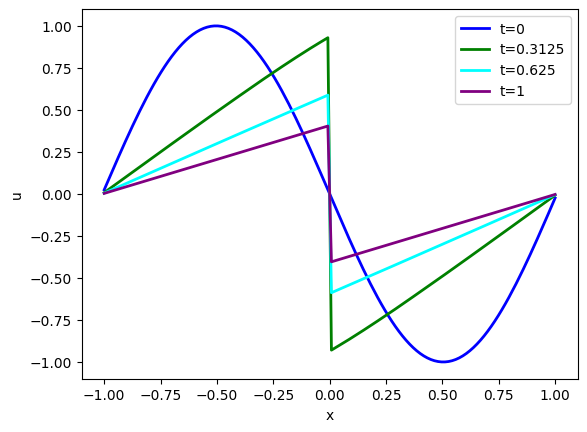

In [18]:
vels = [v.values.numpy('x,vector') for v in velocities] # gives a list of 2D arrays
import pylab
fig = pylab.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue', label="t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label="t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan', label="t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label="t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()

# navier stockes forward simulation

In [19]:
import pylab

In [20]:
DT = 1.5
NU = 0.01

INFLOW = CenteredGrid(Sphere(center=tensor([30,15], channel(vector='x,y')), radius=10), extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100))) * 0.2


In [21]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled at cell centers
velocity = StaggeredGrid(0, extrapolation.ZERO, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled in staggered form at face centers 

Max. velocity and mean marker density: [0.1558497, 0.008125]


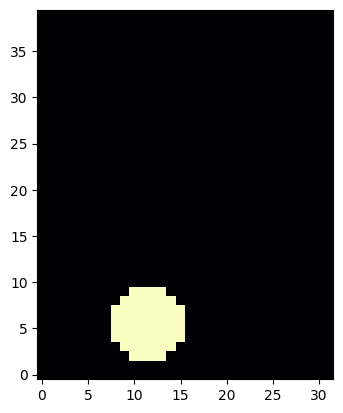

In [22]:
def step(velocity, smoke, pressure, dt=1.0, buoyancy_factor=1.0):
    smoke = advect.semi_lagrangian(smoke, velocity, dt) + INFLOW
    buoyancy_force = (smoke * (0, buoyancy_factor)).at(velocity)  # resamples smoke to velocity sample points
    velocity = advect.semi_lagrangian(velocity, velocity, dt) + dt * buoyancy_force
    velocity = diffuse.explicit(velocity, NU, dt)
    velocity, pressure = fluid.make_incompressible(velocity)
    return velocity, smoke, pressure

velocity, smoke, pressure = step(velocity, smoke, None, dt=DT)

print("Max. velocity and mean marker density: " + format( [ math.max(velocity.values) , math.mean(smoke.values) ] ))

pylab.imshow(np.asarray(smoke.values.numpy('y,x')), origin='lower', cmap='magma')

In [23]:
print(f"Smoke: {smoke.shape}")
print(f"Velocity: {velocity.shape}")
print(f"Inflow: {INFLOW.shape}, spatial only: {INFLOW.shape.spatial}")


Smoke: (xˢ=32, yˢ=40)
Velocity: (xˢ=32, yˢ=40, vectorᶜ=x,y)
Inflow: (xˢ=32, yˢ=40), spatial only: (xˢ=32, yˢ=40)


In [24]:
print(f"Shape content: {velocity.shape.sizes}")
print(f"Vector dimension: {velocity.shape.get_size('vector')}")

Shape content: (32, 40, 2)
Vector dimension: 2


In [25]:
print("Statistics of the different simulation grids:")
print(smoke.values)
print(velocity.values)

# in contrast to a simple tensor:
test_tensor = math.tensor(numpy.zeros([3, 5, 2]), spatial('x,y'), channel(vector="x,y"))
print("Reordered test tensor shape: " + format(test_tensor.numpy('vector,y,x').shape) ) # reorder to vector,y,x 
#print(test_tensor.values.numpy('y,x')) # error! tensors don't return their content via ".values"

Statistics of the different simulation grids:
(xˢ=32, yˢ=40) 0.008 ± 0.039 (0e+00...2e-01)
(xˢ=(x=31, y=32) int64, yˢ=(x=40, y=39) int64, vectorᶜ=x,y) non-uniform
Reordered test tensor shape: (2, 5, 3)


In [26]:
for time_step in range(10):
    velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    print('Computed frame {}, max velocity {}'.format(time_step , np.asarray(math.max(velocity.values)) ))


Computed frame 0, max velocity 0.4630010426044464
Computed frame 1, max velocity 0.8966453075408936
Computed frame 2, max velocity 1.4098880290985107
Computed frame 3, max velocity 2.041123867034912
Computed frame 4, max velocity 2.927957773208618
Computed frame 5, max velocity 3.839484453201294
Computed frame 6, max velocity 4.526943206787109
Computed frame 7, max velocity 4.867983818054199
Computed frame 8, max velocity 5.131080150604248
Computed frame 9, max velocity 5.4838786125183105


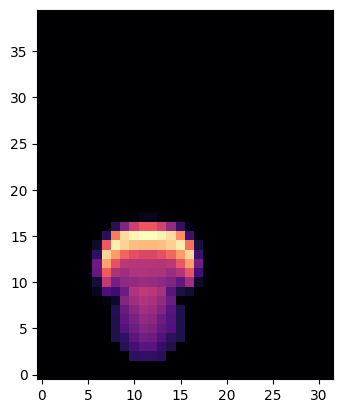

In [27]:
pylab.imshow(smoke.values.numpy('y,x'), origin='lower', cmap='magma')

Computing time step 0
Computing time step 1
Computing time step 2
Computing time step 10


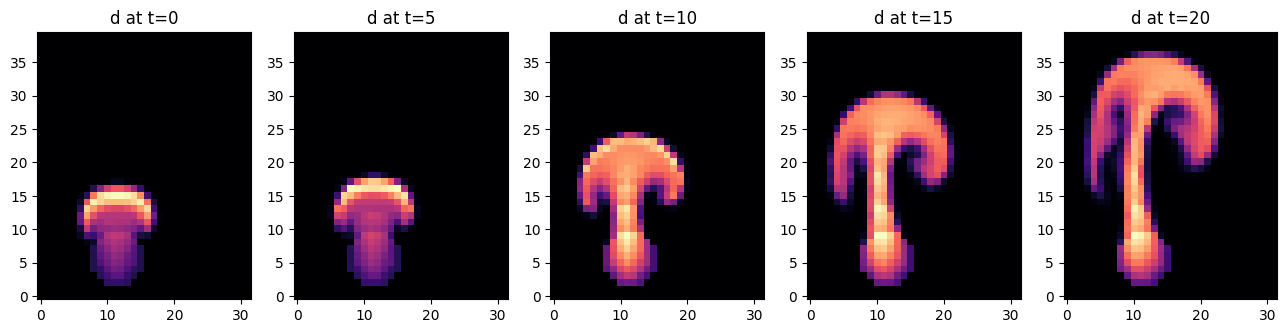

In [28]:
steps = [[ smoke.values, velocity.values.vector[0], velocity.values.vector[1] ]]
for time_step in range(20):
  if time_step<3 or time_step%10==0: 
    print('Computing time step %d' % time_step)
  velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
  if time_step%5==0:
    steps.append( [smoke.values, velocity.values.vector[0], velocity.values.vector[1]] )

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][0].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"d at t={i*5}")

In [ ]:
gradi